# Import Librerie

In [633]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt


from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Definizione funzioni

In [634]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean(np.square(actual - predicted)))

In [635]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/master/synthetic_dataset.csv')    

In [636]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze()

In [637]:
def calcualteLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [638]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Loss", "Train and test set splitter"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizazione Serie Temporali Sintentiche

In [639]:
dataset = getRemoteDataset()

In [640]:
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

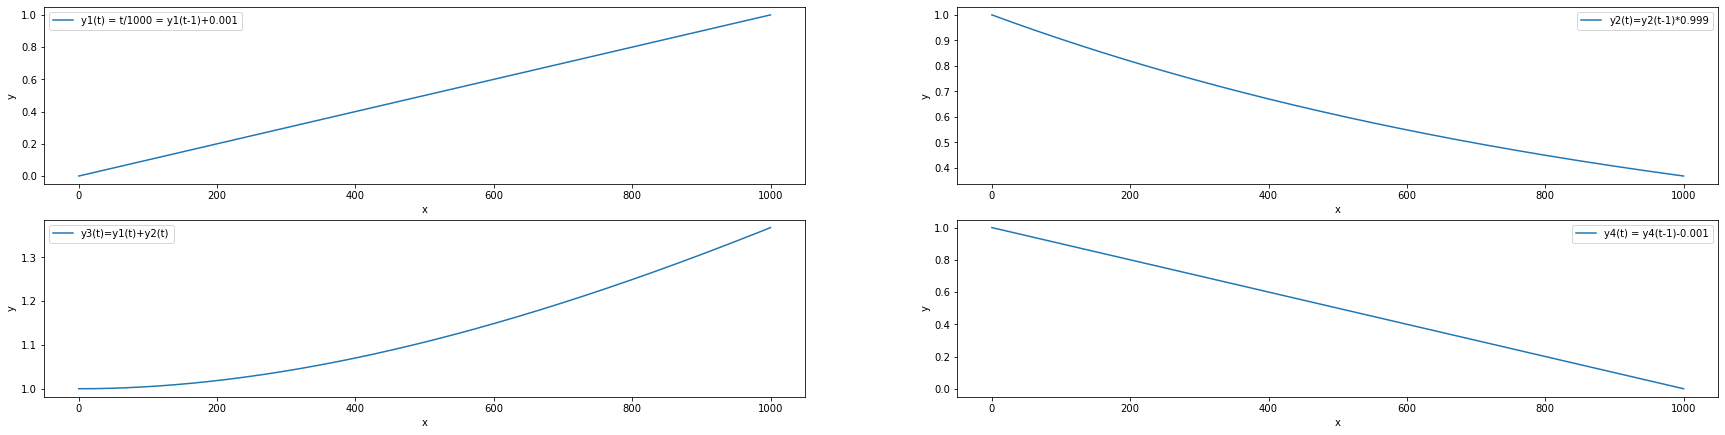

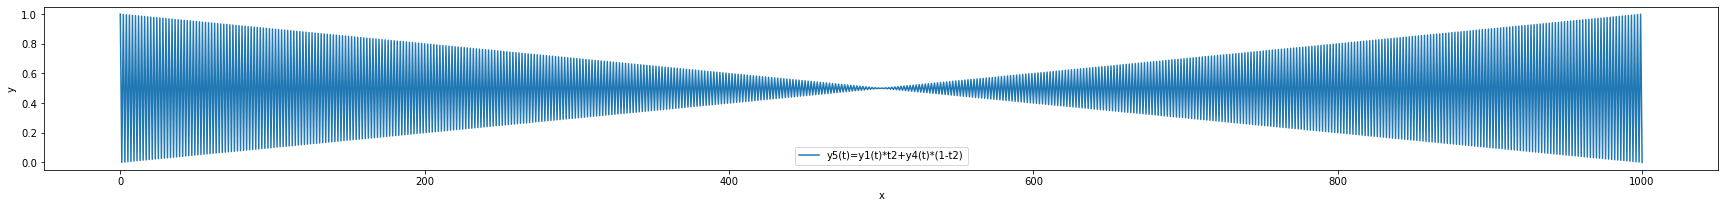

In [641]:
plt.figure(figsize=(30,15))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,3))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t2+y4(t)*(1-t2)")

# DatasetManager e Inizializzazione SVR
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [642]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        self.df = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)

    def __len__(self):
        return len(self.sequences)

    def __train_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[0: int(len(self.sequences)*self.portion)], yCol[0: int(len(self.sequences)*self.portion)]
    
    def __test_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[int(len(self.sequences)*self.portion):], yCol[int(len(self.sequences)*self.portion):]


In [643]:
def svr_model_5(X, y, verbose=False):

    # Ricerca dei parametri ottimali (C e gamma)
    # usando GridSearch con 5-fold Cross Validation
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.05, 0.1, 1, 2, 4, 8, 10],
            'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
        },
        cv=5,
        n_jobs=-1,
        scoring=make_scorer(RMSE_Loss, greater_is_better=False),
        return_train_score=True
    )
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    best_score = grid_result.best_score_
    if verbose is True:
        print("Parametri ottimali:", best_params)
        print("Miglior score:", best_score)

    # Applicazione del modello SVR applicando i parametri ottimali
    best_svr = SVR(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
    best_svr.fit(X, y)
    predicted_sales_train = best_svr.predict(X)

    if verbose is True:
        for d, i, j in zip(X, y, predicted_sales_train):
            print(d,i,j)

    train_rmse = RMSE_Loss(y, predicted_sales_train)
    
    return best_svr, train_rmse, predicted_sales_train

In [644]:
def TestingSVR(X, y, best_svr, verbose=False):
    predicted_sales_test = best_svr.predict(X)
    if verbose is True:
        for d, i, j in zip(X, y, predicted_sales_test):
            print(d,i,j)
    test_rmsse = RMSE_Loss(y, predicted_sales_test)
    return predicted_sales_test, test_rmsse

In [645]:
def executeSVR(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0):
    data = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    print("Dataset: (head - 10)")
    print(data.df.head(10))
    x_train, y_train = data.__train_set__()
    x_test, y_test = data.__test_set__()

    best_svr, train_rmse, y_predicted_in_train = svr_model_5(x_train, y_train)
    y_predicted_in_test, test_rmse = TestingSVR(x_test, y_test, best_svr)

    showPerformanceGraph(
        label = label+" \n RMSE_train("+str(train_rmse)[0:7]+") --- RMSE_test("+str(test_rmse)[0:7]+")",
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze(),
        y_predicted_train=y_predicted_in_train,
        y_predicted_test=y_predicted_in_test,
        loss_train=calcualteLoss(y_train.squeeze(),y_predicted_in_train),
        loss_test= calcualteLoss(y_test.squeeze(), y_predicted_in_test)
    )

# Esecuzione SVR

In [646]:
features_length = _ #Default 1
offset = _ #Default 0
portion_train_test = _ #Default 0.8

Dataset: (head - 10)
       t    t+1
0  0.000  0.001
1  0.001  0.002
2  0.002  0.003
3  0.003  0.004
4  0.004  0.005
5  0.005  0.006
6  0.006  0.007
7  0.007  0.008
8  0.008  0.009
9  0.009  0.010


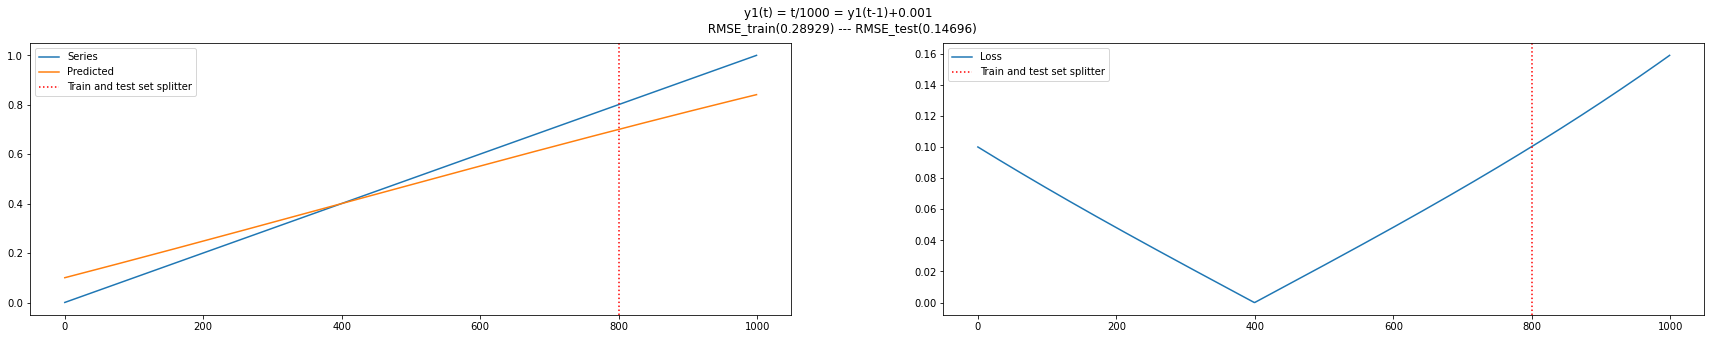

In [647]:
executeSVR("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
          t       t+1
0  1.000000  0.999000
1  0.999000  0.998001
2  0.998001  0.997003
3  0.997003  0.996006
4  0.996006  0.995010
5  0.995010  0.994015
6  0.994015  0.993021
7  0.993021  0.992028
8  0.992028  0.991036
9  0.991036  0.990045


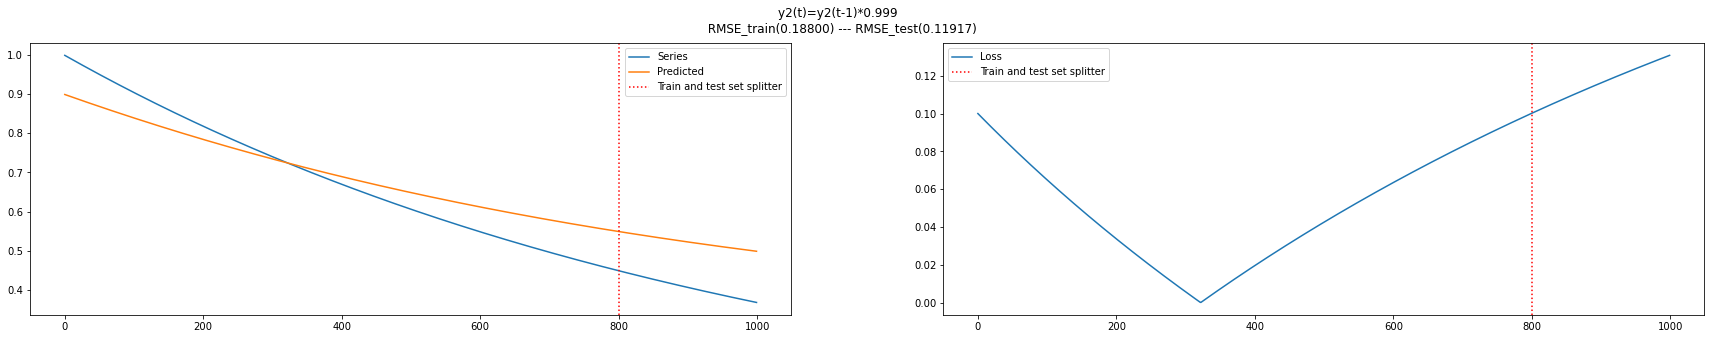

In [648]:
executeSVR("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
          t       t+1
0  1.000000  1.000000
1  1.000000  1.000001
2  1.000001  1.000003
3  1.000003  1.000006
4  1.000006  1.000010
5  1.000010  1.000015
6  1.000015  1.000021
7  1.000021  1.000028
8  1.000028  1.000036
9  1.000036  1.000045


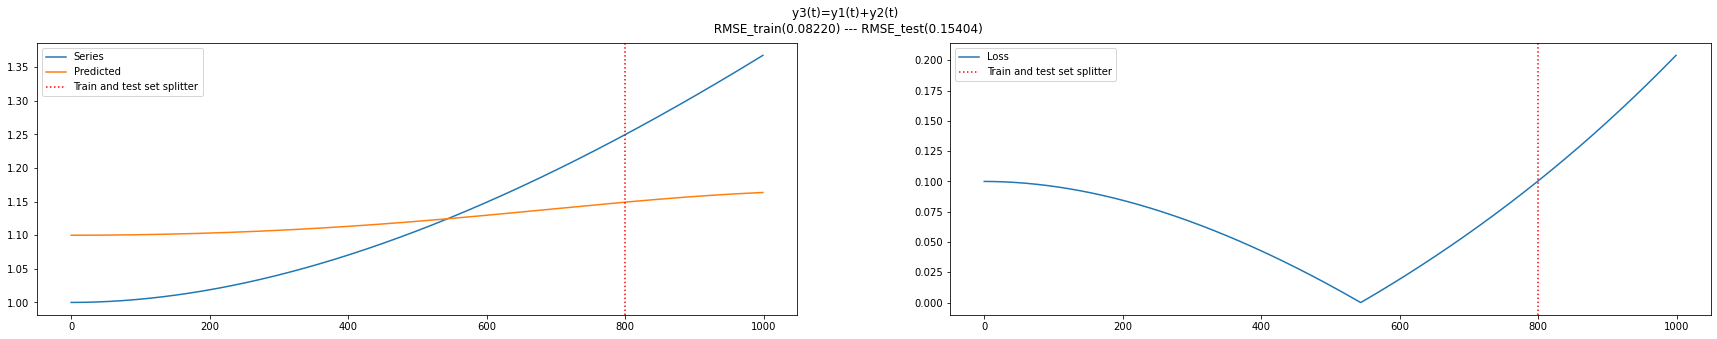

In [649]:
executeSVR("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
       t    t+1
0  1.000  0.999
1  0.999  0.998
2  0.998  0.997
3  0.997  0.996
4  0.996  0.995
5  0.995  0.994
6  0.994  0.993
7  0.993  0.992
8  0.992  0.991
9  0.991  0.990


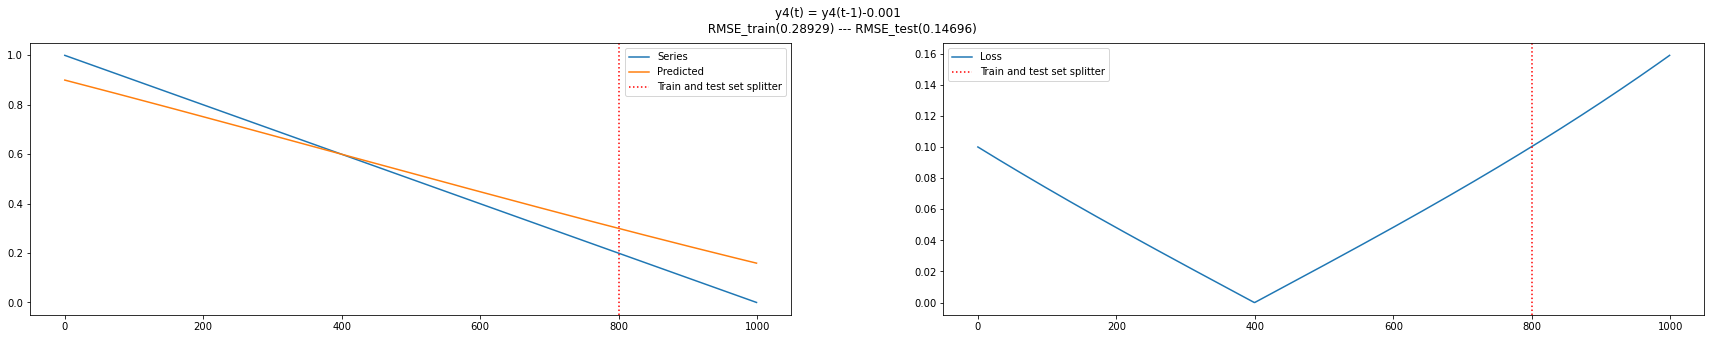

In [650]:
executeSVR("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
       t    t+1
0  1.000  0.001
1  0.001  0.998
2  0.998  0.003
3  0.003  0.996
4  0.996  0.005
5  0.005  0.994
6  0.994  0.007
7  0.007  0.992
8  0.992  0.009
9  0.009  0.990


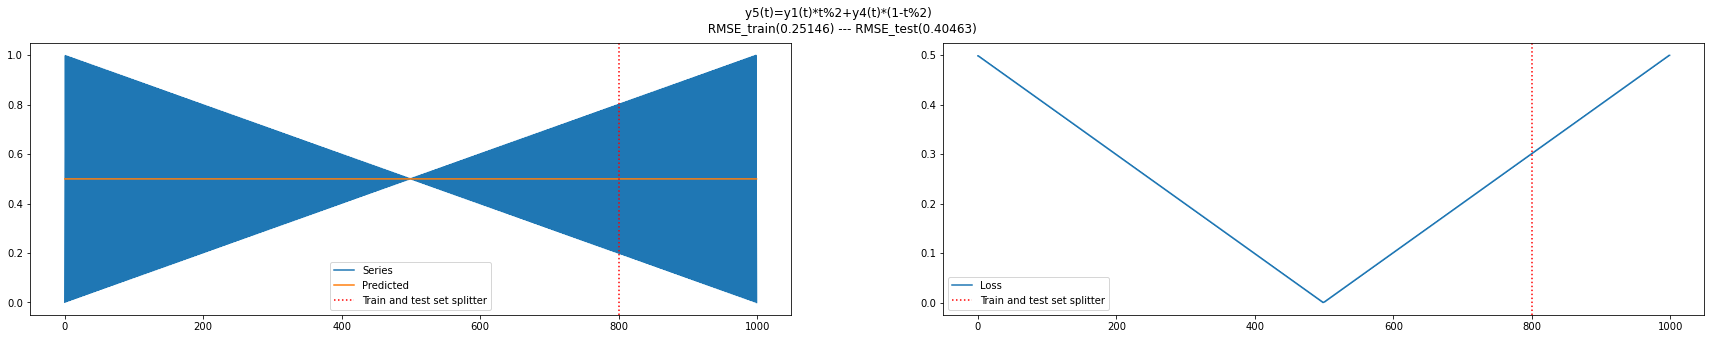

In [651]:
executeSVR("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)